In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
dev = 'cpu'

# Cool resources about autoregressive models
# https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
# https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling

# Autoregressive modeling

$N$ dimensional input with lag $P$.

$\hat{y}_t = f(y_{t-1},y_{t-2},...,y_{t-P})$

We can model this with a fully connected layer

\begin{equation}
X_t | X_{i<t} = \theta_0 + \sum^P_{i=i}{\theta_i X_{t-i}}
\end{equation}

And the whole system as a DNN with nonlinearity $\delta(.)$ at the $l^{th}$ layer:

\begin{equation}
H^l_t = \sigma(\Theta^{l-1}_t\cdot H_t^{l-1})
\end{equation}

# Limitations of fully connected layers
#### 1. **Training** with linear layers is inefficient as autoregressive value needs to be computed for every possible window of size $P$.

This means that we don't have weight preloading strategies like in the case of CNNs. To generate an output in a CNN, we compute the intermediate outputs of a layer for all the sequence before computing the next one. This means that we can implement training un-rolling (since we know the future data points at train time) and avoid computing a single forward pass for every input before processing next one. 

A CNN that implements **casual** processing of inputs is called TCN.

#### 2. The number of weights grows linearily with the receptive field of the model. For multi-time scale models (speech, audio) this becomes quickly an issue.

Fully connected layers don't have implemented downsampling methods such as dilation or stride that would increase receptive field without increasing the number of parameters.

# Graphical model MLPs vs CNNs

# A harmonic series dataset

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [2]:
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(harmonics*torch.sin(self.phases))
        return sample

Let's generate a dataset and plot its content.

240
240


/tools/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


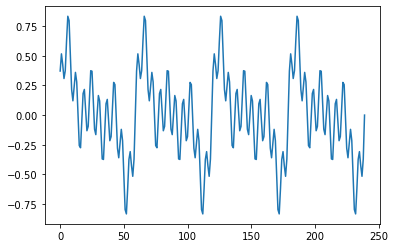

In [3]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)
samples = torch.zeros(signal_len)

for i,sample in enumerate(dataloader):
    samples[i] = sample
fig, ax = plt.subplots()
ax.plot(samples.detach().numpy())
plt.show()

# Autoregressive MLP module

In [4]:
class autoregressiveMLP(nn.Module):
    def __init__(self,in_size,seq_len,hidden_layers,hidden_size,device,use_bias = True):
        super().__init__()
        
        total_in_size = in_size * seq_len
        out_size = in_size
        net = []
        if(hidden_layers == 0):
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
        else:
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            for i in range(hidden_layers):
                net.append(nn.Linear(hidden_size,hidden_size,bias=use_bias))
                net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
        
        self.net = nn.Sequential(*net)

    '''
    Updates circular buffer with new item and process output
    The model predicts x_n from a collection of previous entries.
    Forward process:
        circular buffer contains all prev samples in this order: 
        [x_{n-1} , x_{n-2}, ... , x_{n-P}]
        1. Predict next output from current collection of prev samples.
        2. Update buffer with either current sample or force the correct value.
        3. Return prediction
    
        I think this is wrong
        # Roll and detach previous grad (otherwise it computes all grads through time)
            self.seq = torch.roll(self.seq,1,0).detach()
            self.seq[0,:] = item
            #print(self.seq.view(-1))
            return self.net(self.seq.view(-1))
    
    '''
    def forward(self,seq):
        ''' 

        '''
        #print("net input: {}".format(self.seq.view(-1)))
        pred = self.net(seq.view(-1))
        return pred

# Training and Evaluation function

In [5]:
def evaluate_on_train_data(net,P,target,device,plot=False):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    with torch.no_grad():
        for i, sample in enumerate(target):
            sample = sample.to(device)
            pred = net(seq)
            predictions[i] = pred
            seq = torch.roll(seq,1,0)
            seq[0] = sample # Teacher forcing
            seq.detach()

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON TRAIN DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().numpy())
        ax.plot(predictions.detach().numpy())
        plt.show()
    return eval_loss
    
def evaluate_dry(net,P,target,device,plot=False):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    with torch.no_grad():
        for i in range(target_len):
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[i]
            seq.detach()

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[DRY TEST] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().cpu().numpy())
        ax.plot(predictions.detach().cpu().numpy())
        plt.show()
    return eval_loss

def evaluate_section(net,P,target,section,device):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    l1 = int(target_len*section)
    l2 = target_len - l1
    with torch.no_grad():
        for i in range(l1):
            sample = target[i].to(device)
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = sample # Teacher forcing
            seq.detach()
        print("At {}, we have in sequence:".format(section))
        fig, ax = plt.subplots()
        ax.plot(seq.detach().cpu().numpy())
        plt.show()
        # Continue predicting without previous reference
        for i in range(l2):
            predictions[l1 + i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[l1 + i] # No teacher forcing
            seq.detach()

    fig, ax = plt.subplots()
    eval_loss = torch.sum(torch.abs(target-predictions))
    print("[SECTION TEST] eval loss {}".format(eval_loss))
    ax.plot(target.detach().cpu().numpy())
    ax.plot(predictions.detach().cpu().numpy())
    plt.show()
    
    
def train(net,P,epochs,dataloader,target,device,teacher_force = False):
    net.train()
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    best_eval_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, sample in enumerate(dataloader):
            sample = sample.to(device)
            optimizer.zero_grad()
            # forward + backward + optimize
            prediction = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = sample if teacher_force else prediction
            seq.detach()

            loss = criterion(prediction, sample)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()


        eval_loss = evaluate_dry(net,P,target,device)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(net.state_dict(), 'best.pt')
            
        if(epoch % 50 == 0): 
            #fig, ax = plt.subplots()
            #ax.plot(net.seq.detach().numpy())
            #plt.show()
            print("[EPOCH {}] train loss {} - best eval {}".format(epoch,running_loss,best_eval_loss))
            #net.eval()

            #evaluate_on_train_data(net,target)
            
            #net.train()
        running_loss = 0.0

    print('Finished Training')


# Training the MLP

Here, if we don't use `teacher_forcing` then the model does not train.
I believe we may not have to `.detach()` the circular buffer for every new sample we input, this way we would be able to effectively backpropagate through time. Problem is, this constructs very complex gradient trees.

In [6]:
def train_and_test_MLP(P,hidden_size,n_hidden_layers,dataloader,epochs,device,eval_section=0.5):
    #EPOCHS = 400
    # Declare a MLP model
    #seq_length = 100
    #hidden_size = 32
    #n_layers = 3
    samples = torch.zeros(len(dataloader))
    for i,sample in enumerate(dataloader):
        samples[i] = sample

    in_size = 1
    
    net = autoregressiveMLP(in_size,P,n_hidden_layers,hidden_size,device)
    net = net.to(device)
    
    teacher_force = True
    train(net,P,epochs,dataloader,samples,device,teacher_force)
    
    net.load_state_dict(torch.load('best.pt'))
    net.eval()
    evaluate_on_train_data(net,P,samples,device,plot=True)
    
    evaluate_dry(net,P,samples,device,plot=True)
    
    evaluate_section(net,P,samples,eval_section,device)

[EPOCH 0] train loss 49.025811925530434 - best eval 65.56946563720703
[EPOCH 50] train loss 6.2151164300739765 - best eval 55.2802848815918
Finished Training
[TEST ON TRAIN DATA] eval loss 17.891830444335938


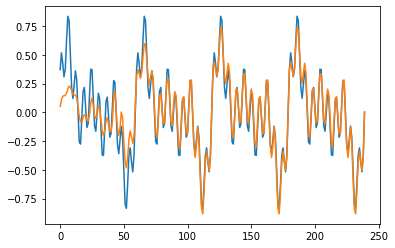

[DRY TEST] eval loss 55.2802848815918


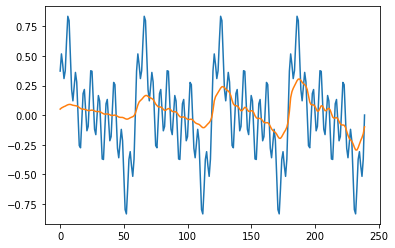

At 0.5, we have in sequence:


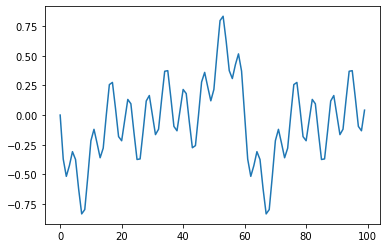

[SECTION TEST] eval loss 21.5738582611084


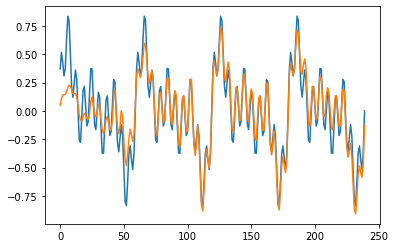

In [7]:
train_and_test_MLP(100,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)


[EPOCH 0] train loss 56.79747863858938 - best eval 81.01982879638672
[EPOCH 50] train loss 7.541401382535696 - best eval 52.11760711669922
Finished Training
[TEST ON TRAIN DATA] eval loss 19.610387802124023


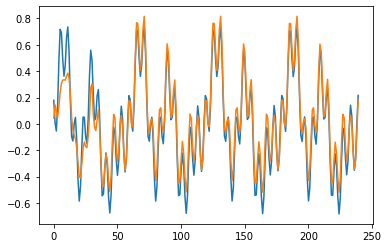

[DRY TEST] eval loss 52.11760711669922


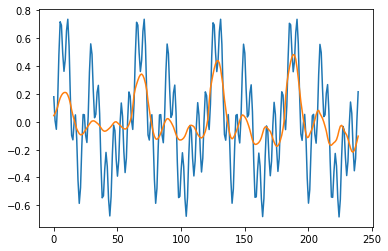

At 0.5, we have in sequence:


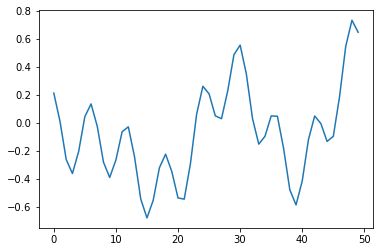

[SECTION TEST] eval loss 23.734195709228516


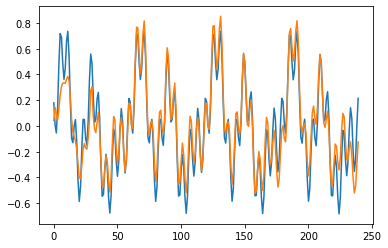

In [8]:
train_and_test_MLP(50,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 66.670065831393 - best eval 68.97139739990234
[EPOCH 50] train loss 8.990677896887064 - best eval 68.7980728149414
Finished Training
[TEST ON TRAIN DATA] eval loss 15.12893295288086


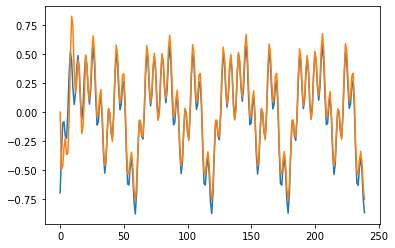

[DRY TEST] eval loss 67.90421295166016


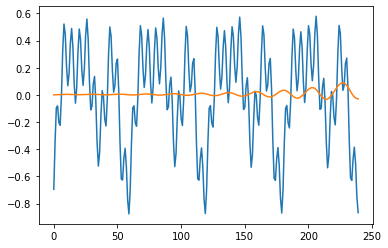

At 0.5, we have in sequence:


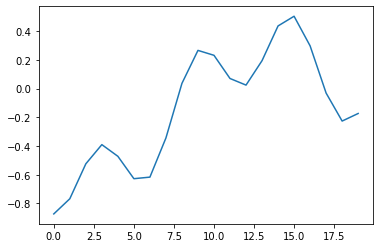

[SECTION TEST] eval loss 60.32831954956055


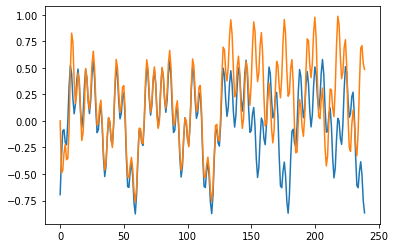

In [10]:
train_and_test_MLP(20,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 57.673421669751406 - best eval 93.71104431152344
[EPOCH 50] train loss 9.725274596363306 - best eval 65.07219696044922
Finished Training
[TEST ON TRAIN DATA] eval loss 14.572427749633789


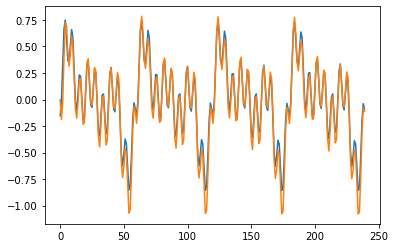

[DRY TEST] eval loss 64.96690368652344


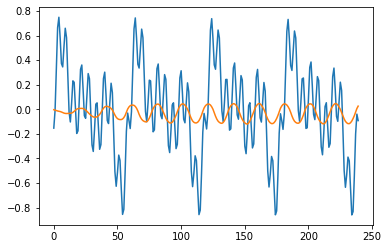

At 0.5, we have in sequence:


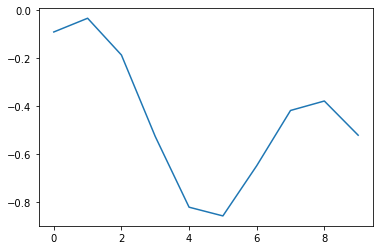

[SECTION TEST] eval loss 253.87551879882812


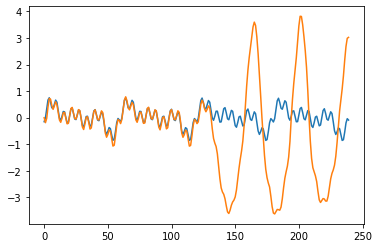

In [11]:
train_and_test_MLP(10,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 52.753989844582975 - best eval 36818308.0
[EPOCH 50] train loss 11.557295082136989 - best eval 68.84007263183594
Finished Training
[TEST ON TRAIN DATA] eval loss 24.52393913269043


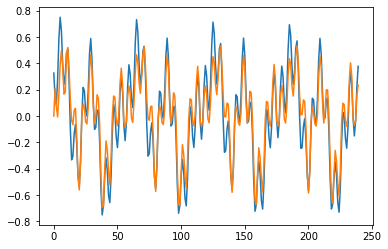

[DRY TEST] eval loss 68.84007263183594


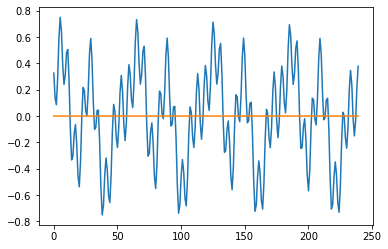

At 0.5, we have in sequence:


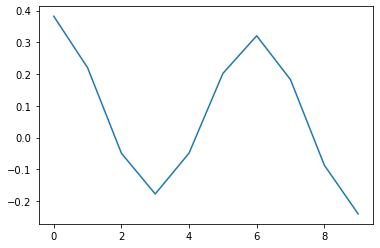

[SECTION TEST] eval loss 46.836692810058594


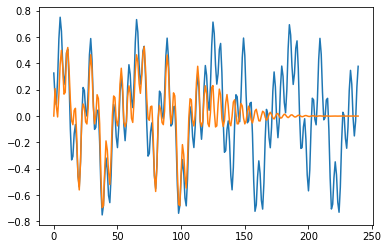

In [12]:
train_and_test_MLP(10,128,3,dataloader,epochs=100,device=dev,eval_section=0.5)